In [1]:
import time
import os
import sys
import numpy as np

#import ipympl
import matplotlib
matplotlib.use('nbagg')
#from matplotlib import style
#style.use('ggplot')

import matplotlib.pyplot as plt

import astropy.units as u
from astropy import stats
from astropy.io import fits
from mmtwfs.wfs import *
from mmtwfs.zernike import *
from mmtwfs.telescope import MMT

from pathlib import Path
from astropy.modeling import models, fitting

%load_ext autoreload
%autoreload 2

In [73]:
plt.close('all')
home = Path(os.environ['HOME'])
mmirs = WFSFactory(wfs="mmirs", nzern=21)
f9wfs = WFSFactory(wfs="newf9", nzern=21)
f5wfs = WFSFactory(wfs="f5", nzern=21)

<IPython.core.display.Javascript object>


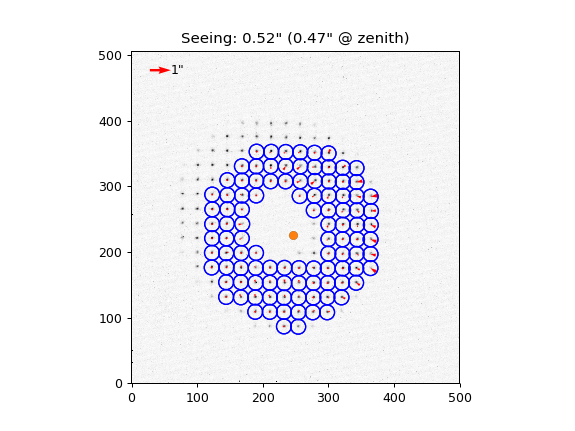

In [74]:
mmirs_file = home / "MMT/mmtwfs/mmtwfs/data/test_data/mmirs_wfs_0150.fits"
mmirs_results = mmirs.measure_slopes(mmirs_file, plot=True)
mmirs_results['figures']['slopes'].show()

<IPython.core.display.Javascript object>


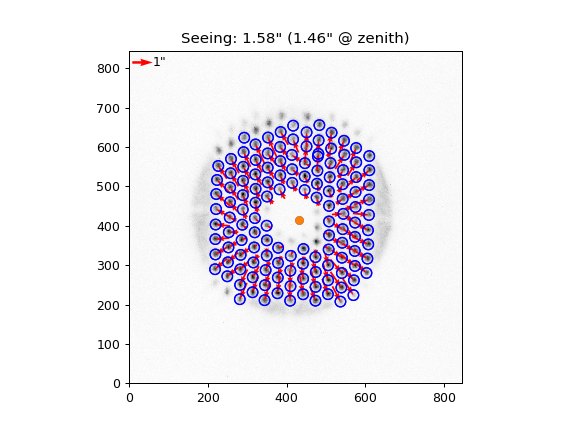

In [75]:
f9_file = home / "MMT/mmtwfs/mmtwfs/data/test_data/test_newf9.fits"
f9_results = f9wfs.measure_slopes(f9_file, 'blue', plot=True)
f9_results['figures']['slopes'].show()

<IPython.core.display.Javascript object>


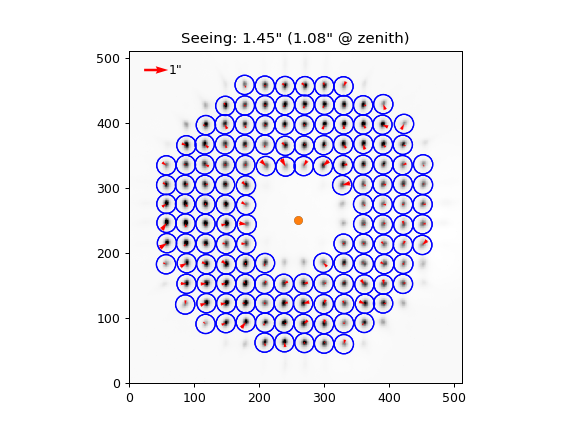

In [76]:
f5_file = home / "MMT/mmtwfs/mmtwfs/data/test_data/auto_wfs_0037_ave.fits"
f5_results = f5wfs.measure_slopes(f5_file, 'hecto', plot=True)
f5_results['figures']['slopes'].show()

In [77]:
def ZernikeGrad(Z, x, y, atype):

    if(len(Z) > 21):
        print('ZernikeGrad() is not implemented with >22 terms')
        return
    elif len(Z) < 21:
        Z = np.hstack((Z, np.zeros(22 - len(Z))))

    x2 = x * x
    y2 = y * y
    xy = x * y
    r2 = x2 + y2

    if (atype == 'dx'):
        d = 0. * x  # to make d an array with the same size as x
        d = d + Z[0] * 1.
        d = d + Z[1] * 0.
        d = d + Z[2] * 4. * x
        d = d + Z[3] * 2. * y
        d = d + Z[4] * 2. * x
        d = d + Z[5] * 6. * xy
        d = d + Z[6] * (9. * x2 + 3. * y2 - 2.)
        d = d + Z[7] * 6. * xy
        d = d + Z[8] * (3. * x2 - 3. * y2)
        d = d + Z[9] * 12. * x * (2. * (x2 + y2) - 1.)
        d = d + Z[10] * x * (16. * x2 - 6.)
        d = d + Z[11] * y * (24. * x2 + 8. * y2 - 6.)
        d = d + Z[12] * 4. * x * (x2 - 3. * y2)
        d = d + Z[13] * 4. * y * (3. * x2 - y2)
        d = d + Z[14] * (x2 * (50. * x2 + 60. * y2 - 36.) + y2 * (10. * y2 - 12.) + 3.)
        d = d + Z[15] * (xy * (40. * r2 - 24.))
        d = d + Z[16] * (x2 * (25. * x2 - 12. - 30. * y2) + y2 * (12. - 15. * y2))
        d = d + Z[17] * (4. * xy * (-6. + 15. * x2 + 5. * y2))
        d = d + Z[18] * 5. * (x2 * (x2 - 6. * y2) + y2 * y2)
        d = d + Z[19] * 20. * xy * (x2 - y2)
        d = d + Z[20] * 24. * x * (1. + x2 * (10. * y2 - 5. + 5. * x2) + y2 * (5. * y2 - 5.))

    elif (atype, 'dy'):

        d = 0. * y
        d = d + Z[0] * 0.
        d = d + Z[1] * 1.
        d = d + Z[2] * 4. * y
        d = d + Z[3] * 2. * x
        d = d + Z[4] * (-2.) * y
        d = d + Z[5] * (3. * x2 + 9. * y2 - 2.)
        d = d + Z[6] * 6. * xy
        d = d + Z[7] * (3. * x2 - 3. * y2)
        d = d + Z[8] * (-6.) * xy
        d = d + Z[9] * 12. * y * (2. * (x2 + y2) - 1.)
        d = d + Z[10] * y * (6. - 16. * y2)
        d = d + Z[11] * x * (8. * x2 + 24. * y2 - 6.)
        d = d + Z[12] * 4. * y * (y2 - 3. * x2)
        d = d + Z[13] * 4. * x * (x2 - 3. * y2)
        d = d + Z[14] * (xy * (40. * r2 - 24.))
        d = d + Z[15] * (x2 * (10. * x2 + 60. * y2 - 12.) + y2 * (50. * y2 - 36.) + 3.)
        d = d + Z[16] * (4. * xy * (6. - 5. * x2 - 15. * y2))
        d = d + Z[17] * (y2 * (-25. * y2 + 12. + 30. * x2) + x2 * (-12. + 15. * x2))
        d = d + Z[18] * 20. * xy * (y2 - x2)
        d = d + Z[19] * 5. * (x2 * (x2 - 6. * y2) + y2 * y2)
        d = d + Z[20] * 24. * y * (1. + y2 * (10. * x2 - 5. + 5. * y2) + x2 * (5. * x2 - 5.))

    return d

In [78]:
noll_coefficient(22)

2.6457513110645907

In [79]:
np.sqrt(7)

2.6457513110645907

In [80]:
def slope_chisq(zvec, coords, slopes, weights=1.0):
    x = coords[0]
    y = coords[1]
    xslope = slopes[0]
    yslope = slopes[1]
    pred_xslope = ZernikeGrad(zvec, x, y, atype='dx')
    pred_yslope = ZernikeGrad(zvec, x, y, atype='dy')
    d_sq = (xslope - pred_xslope)**2 + (yslope - pred_yslope)**2
    d_sq /= weights
    chisq = d_sq.sum()
    return chisq

In [40]:
slopes = -f5wfs.tiltfactor * f5_results['slopes']
pup_coords = f5wfs.modes['hecto']['reference'].pup_coords(f5wfs.pup_size/2.)

In [41]:
pup_coords[0].shape, slopes[1].shape

((151,), (151,))

In [42]:
from scipy import optimize

In [64]:
zfit = np.zeros(21)
results = optimize.minimize(slope_chisq, zfit, args=(pup_coords, slopes), method='BFGS')

In [65]:
results

      fun: 704845254.5015743
 hess_inv: array([[  2.08995781e-03,  -1.91404912e-03,   1.59631817e-04,
         -9.73066119e-04,  -2.25459326e-04,   1.47016017e-03,
         -7.08091900e-04,   1.15250676e-03,  -9.13958786e-05,
          2.47034793e-04,  -7.77159138e-05,   2.96222734e-04,
          1.25634866e-04,   4.95920547e-04,   2.88135295e-04,
         -7.87153228e-04,  -5.06109304e-05,  -4.33567267e-04,
         -8.99639864e-05,  -7.63826341e-05,  -2.74137169e-04],
       [ -1.91404912e-03,   2.61233659e-03,  -3.10133578e-04,
          7.53258659e-04,   6.87225041e-04,  -1.46927232e-03,
          7.17073313e-04,  -1.57365413e-03,   2.60806674e-04,
         -1.70718283e-04,  -2.21207347e-04,  -4.18640370e-04,
         -3.29129764e-04,  -6.49992406e-04,  -2.40640957e-04,
          5.69719320e-04,   6.14463804e-05,   5.27708321e-04,
         -1.15321257e-04,  -1.38917282e-04,   2.40383913e-04],
       [  1.59631817e-04,  -3.10133578e-04,   3.19860328e-04,
         -2.60582703e-04,  -

In [66]:
z = ZernikeVector()
z.from_array(results['x'], modestart=2)
z

Fringe Coefficients
 Z02:       209 nm 	 X Tilt (1, 1)
 Z03:       204 nm 	 Y Tilt (1, -1)
 Z04: -2.57e+03 nm 	 Defocus (2, 0)
 Z05:       170 nm 	 Primary Astig at 45° (2, -2)
 Z06:       672 nm 	 Primary Astig at 0° (2, 2)
 Z07:      -171 nm 	 Primary Y Coma (3, -1)
 Z08:      -222 nm 	 Primary X Coma (3, 1)
 Z09:     -48.8 nm 	 Y Trefoil (3, -3)
 Z10:       178 nm 	 X Trefoil (3, 3)
 Z11:      -356 nm 	 Primary Spherical (4, 0)
 Z12:      -103 nm 	 Secondary Astigmatism at 0° (4, 2)
 Z13:      58.2 nm 	 Secondary Astigmatism at 45° (4, -2)
 Z14:       179 nm 	 X Tetrafoil (4, 4)
 Z15:       224 nm 	 Y Tetrafoil (4, -4)
 Z16:        17 nm 	 Secondary X Coma (5, 1)
 Z17:       120 nm 	 Secondary Y Coma (5, -1)
 Z18:      4.61 nm 	 Secondary X Trefoil (5, 3)
 Z19:     -8.01 nm 	 Secondary Y Trefoil (5, -3)
 Z20:      81.2 nm 	 X Pentafoil (5, 5)
 Z21:     -14.2 nm 	 Y Pentafoil (5, -5)
 Z22:       158 nm 	 Secondary Spherical (6, 0)

Total RMS: 	 	 1.53e+03 nm

360.3495170352254 nm
Fringe Coefficients
 Z02:      22.6 nm 	 X Tilt (1, 1)
 Z03:      -128 nm 	 Y Tilt (1, -1)
 Z04: -2.47e+03 nm 	 Defocus (2, 0)
 Z05:       118 nm 	 Primary Astig at 45° (2, -2)
 Z06:       583 nm 	 Primary Astig at 0° (2, 2)
 Z07:      -100 nm 	 Primary Y Coma (3, -1)
 Z08:      -146 nm 	 Primary X Coma (3, 1)
 Z09:     -34.6 nm 	 Y Trefoil (3, -3)
 Z10:       110 nm 	 X Trefoil (3, 3)
 Z11:      -368 nm 	 Primary Spherical (4, 0)
 Z12:     -89.2 nm 	 Secondary Astigmatism at 0° (4, 2)
 Z13:      -164 nm 	 Secondary Astigmatism at 45° (4, -2)
 Z14:      2.54 nm 	 X Tetrafoil (4, 4)
 Z15:      64.1 nm 	 Y Tetrafoil (4, -4)
 Z16:       107 nm 	 Secondary X Coma (5, 1)
 Z17:      42.9 nm 	 Secondary Y Coma (5, -1)
 Z18:      56.5 nm 	 Secondary X Trefoil (5, 3)
 Z19:     -20.4 nm 	 Secondary Y Trefoil (5, -3)
 Z20:      10.1 nm 	 X Pentafoil (5, 5)
 Z21:      4.43 nm 	 Y Pentafoil (5, -5)
 Z22:       407 nm 	 Secondary Spherical (6, 0)

Total RMS: 	 	 1.47e+03 nm



<IPython.core.display.Javascript object>


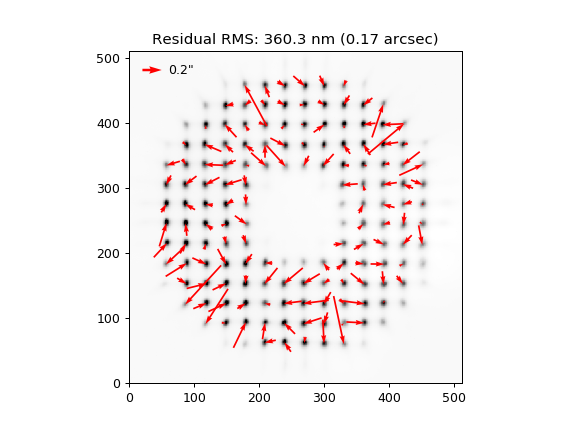

In [81]:
zresults = f5wfs.fit_wavefront(f5_results, plot=True)
print(zresults['residual_rms'])
print(zresults['raw_zernike'].pretty_print())
zresults['resid_plot'].show()